## Step 2: Quasi-conformal spherical parameterization of a genus-0 surface, $S_{ref}(x,y,z)$ 

Theoretically, any genus-0 3D surface can be mapped to a sphere. Practically, there is no unique way to do this. Various ways can be found to do this in the literature. What is good depends on the downstream application and whether we care about speed and size of mesh (i.e. the number of vertices and faces).

u-Unwrap3D implements a fast iterative relaxation algorithm for quasi-conformal spherical parameterization. This does not give the lowest conformal error however it results for better triangle quality to enable area distortion relaxation in the next step to get a quasi-equiareal parameterization. 

**Note:** u-Unwrap3D also provides implementation of the spherical quasiconformal map of [Choi et al.](https://arxiv.org/abs/1203.6819) which guarantees a bijective mapping with no foldovers, and has lower conformal error but we find yields poorer triangle quality (smaller area triangles and smaller minimum angle), and is very slow, scaling poorly for larger meshes (>100k vertices).

### Load $S_{ref}(x,y,z)$  mesh and create an analysis save folder

We assume the user has worked through step 1 which generates and saves genus-0 reference surface for an input cell surface mesh to the folder `example_results/bleb_example/step1_cMCF_reference`. Moreover this surface has been colored by curvature or molecular intensity. 

In [2]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import scipy.io as spio
import igl

# example cell used
imgfolder = 'example_data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step2_confocal_sphere_param')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


# load the pre-computed genus-0 reference surface mesh for the cell
S_ref_folder = 'example_results/%s/step1_cMCF_reference' %(basefname)
S_ref_file = os.path.join(S_ref_folder, 
                            'unwrap_cMCF_Sref_mesh_H_color.obj') 
mesh = meshtools.read_mesh(S_ref_file)


### Conformal mapping of  $S_{ref}(x,y,z)$ onto the 3D unit sphere to get $S_{\text{ref}}^{\mathcal{Q}}(x,y,z)$

We will perform the spherical mapping using the i) recommended iterative approach and ii) the quasiconformal mapping of [Choi et al.](https://arxiv.org/abs/1203.6819) to show the difference in timing and in the deformation errors. 

**i) Iterative conformal spherical map (preferred if performing equiareal parameterization, and large meshes)**

This method first directly projects the mesh onto the unit sphere by normalizing the vertex displacement relative to the mesh centroid $(v-c)$, i.e. $v\leftarrow \frac{v-c}{|v-c|}$. We then apply cMCF iteratively to 'untangle' the mesh directly on the sphere using the uniform Laplacian, and the mass matrix from the robust Laplacian construction. The result is always a spherical map. A valid bijective spherical map is one with no foldovers i.e no inverted faces. For most shapes, we get fast convergence within 5 iterations. 

**ii) Direct quasiconformal spherical map of [Choi et al.](https://arxiv.org/abs/1203.6819)**

This method leverages stereographic projection and attempts to find a quasiconformal map by solving the Beltrami equation. Not robust for triangle quality. Will error for non genus-0 input, is memory-intensive and slow. Result can be more challenging to apply area-distortion relaxation to (more parameter tuning). Use for simpler or more downsamples meshes, or when the objective is to get a lower quasiconformal error.   

In [3]:
# explicitly expose the vertex and faces.
v = mesh.vertices.copy()
f = mesh.faces.copy()


# import time module for timing
import time

""" 
1) Iterative conformal spherical map (*recommended default*, faster, more robust, better triangle quality)
""" 
t1_iterative = time.time()
sphere_xyz_iterative, n_inverted_faces = meshtools.iterative_tutte_spherical_map(v,f, 
                                                               deltaL = 5e-3, # like the cMCF, controls speed of convergence. 
                                                               min_iter=5, # return as soon as iteration number > min_iter, and number of inverted faces is 0  
                                                               max_iter=25, # run this many iterations to see if number of inverted reduces to 0
                                                               mollify_factor=1e-5, 
                                                               scale=1.) # gives just the vertices.
assert(n_inverted_faces[-1]==0) # the output takes the last iteration. 
t2_iterative = time.time()

print('printed number of inverted faces per iteration')
print(n_inverted_faces)


"""
2) Direct quasiconformal spherical map of Choi et al. (only for obtaining lower conformal error) 
"""
t1_direct = time.time()
sphere_xyz_direct = meshtools.direct_spherical_conformal_map(v,f) # gives just the vertices.
t2_direct = time.time()

print('recommended iterative conformal: ', t2_iterative-t1_iterative)
print('Choi et al. direct conformal: ', t2_direct-t1_direct)

printed number of inverted faces per iteration
[0, 0, 0, 0, 0, 0]
recommended iterative conformal:  4.803401231765747
Choi et al. direct conformal:  175.45185112953186


In [4]:
# create mesh for iterative
sphere_mesh_iterative = mesh.copy() # this helps to copy the existing colormap
sphere_mesh_iterative.vertices = sphere_xyz_iterative.copy()

tmp = sphere_mesh_iterative.export(os.path.join(savefolder, 'iterative-conformal_sphere_param_Sref_%s.obj' %(basefname)))

triangle_props_iterative = meshtools.measure_triangle_props(sphere_mesh_iterative, clean=True)

print('triangle props iterative:')
print(triangle_props_iterative)
print('=========================')

# create mesh for Choi direct method
sphere_mesh_direct = mesh.copy() # this helps to copy the existing colormap
sphere_mesh_direct.vertices = sphere_xyz_direct.copy()

tmp = sphere_mesh_direct.export(os.path.join(savefolder, 'direct-conformal_sphere_param_Sref_%s.obj' %(basefname)))

triangle_props_direct = meshtools.measure_triangle_props(sphere_mesh_direct, clean=True)

print('triangle props direct:')
print(triangle_props_direct)
print('=========================')

triangle props iterative:
{'min_angle': 36.91699032829735, 'avg_angle': 60.0, 'max_angle': 97.24459281631464, 'std_dev_angle': 5.522258780064003, 'min_quality': 0.7482094443199341, 'avg_quality': 0.9863552184561242, 'max_quality': 0.9999999186917886, 'quality': array([0.9766042 , 0.99781563, 0.99767575, ..., 0.98342149, 0.99156188,
       0.9471116 ]), 'angles': array([[1.12463085, 0.87489113, 1.14207068],
       [1.04186309, 1.09648491, 1.00324465],
       [1.00405425, 1.03800105, 1.09953736],
       ...,
       [1.10131324, 0.90269963, 1.13757978],
       [1.01041097, 1.15312723, 0.97805445],
       [0.9617505 , 0.86336746, 1.3164747 ]])}
triangle props direct:
{'min_angle': 33.54104213592802, 'avg_angle': 60.00000000000001, 'max_angle': 104.19455840518937, 'std_dev_angle': 8.547885460935499, 'min_quality': 0.665757418560149, 'avg_quality': 0.9679643895747508, 'max_quality': 0.9999996699327401, 'quality': array([0.98736868, 0.991581  , 0.99162982, ..., 0.7887286 , 0.98230283,
       

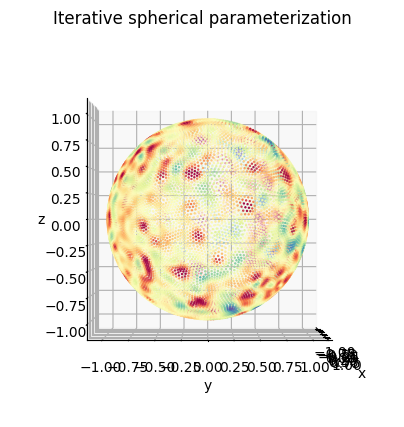

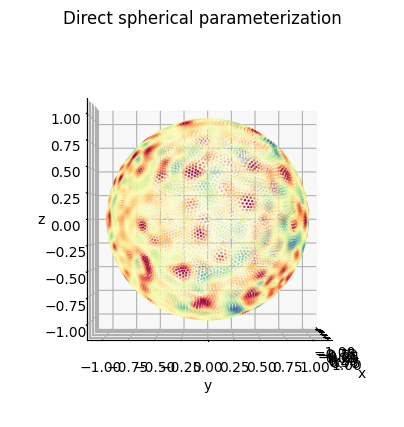

In [5]:
"""
Plotting using matplotlib for comparison. The final version should have vertices more evenly distributed over the sphere. 
"""
import unwrap3D.Visualisation.plotting as plotting 
import pylab as plt 

sampling = 1 # plot every just so its not fully dense in the plot so we don't see anything!

# plotting the before
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('Iterative spherical parameterization')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(sphere_mesh_iterative.vertices[::sampling,2], 
           sphere_mesh_iterative.vertices[::sampling,1],
           sphere_mesh_iterative.vertices[::sampling,0], 
           s=0.5,
           c=sphere_mesh_iterative.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0, 0)
plotting.set_axes_equal(ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# plotting the after
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('Direct spherical parameterization')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(sphere_mesh_direct.vertices[::sampling,2], 
           sphere_mesh_direct.vertices[::sampling,1],
           sphere_mesh_direct.vertices[::sampling,0], 
           s=0.5,
           c=sphere_mesh_direct.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0, 0)
plotting.set_axes_equal(ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Quantifying and colormapping the conformal and equiareal distortion error of the spherical parameterization

We compute the conformal and equiareal errors for the iterative spherical parameterization to be used in the next step. We will also show how to map this onto the mesh. 

In [6]:
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm 

"""
Conformal error
"""
conformal_error = meshtools.quasi_conformal_error(v, 
                                                  sphere_xyz_iterative, 
                                                  f)
# color the error
conformal_error_colors = vol_colors.get_colors(conformal_error[1], colormap=cm.jet, vmin=1., vmax=1.5)

sphere_conformal_error = meshtools.create_mesh(vertices=sphere_xyz_iterative,
                                               faces=f,
                                               face_colors=np.uint8(255*conformal_error_colors[...,:3]))
tmp = sphere_conformal_error.export(os.path.join(savefolder, 
                                           'conformal_sphere_param_Sref_%s_conformal-error.obj' %(basefname)))

"""
Area distortion error
"""
area_distortion_error = meshtools.area_distortion_measure(v, 
                                                          sphere_xyz_iterative, 
                                                          f)  
area_distortion_error_colors = vol_colors.get_colors(np.log(area_distortion_error), 
                                                     colormap=cm.coolwarm, 
                                                     vmin=-3, 
                                                     vmax=3)

sphere_areal_error = sphere_conformal_error.copy()
sphere_areal_error.visual.face_colors = np.uint8(255*area_distortion_error_colors[...,:3]).copy()
tmp = sphere_areal_error.export(os.path.join(savefolder, 
                                       'conformal_sphere_param_Sref_%s_log_equiareal-error.obj' %(basefname)))

# save the statistics
spio.savemat(os.path.join(savefolder, 
                          'conformal_sphere-param_conformal_area_errors.mat'), 
                          {'conformal_Jac_eigvals': conformal_error[0], 
                          'conformal_stretch_factors': conformal_error[1], 
                          'mean_conformal_stretch_factors': conformal_error[2], 
                          'conformal_tri_area_pairs': conformal_error[3], 
                          'conformal_area_distortion_factor': area_distortion_error})

We now also compute the errors for the Choi direct quasiconformal map for comparison.   

In [7]:
mean_conformal_error_iterative = conformal_error[2] # ideal is 1
mean_equiareal_error_iterative = np.nanmean(area_distortion_error) # ideal is 1 

print('quasiconformal error of iterative method:', mean_conformal_error_iterative)
print('mean equiareal error of iterative method:', mean_equiareal_error_iterative)
print('-----------------------------------------')

# compute mean conformal and equiareal for direct method
conformal_error_direct = meshtools.quasi_conformal_error(v, 
                                                        sphere_xyz_direct, 
                                                        f)
area_distortion_error_direct = meshtools.area_distortion_measure(v, 
                                                                sphere_xyz_direct, 
                                                                f)
mean_conformal_error_direct = conformal_error_direct[2] # ideal is 1
mean_equiareal_error_direct = np.nanmean(area_distortion_error_direct) # ideal is 1 

print('quasiconformal error of direct method:', mean_conformal_error_direct)
print('mean equiareal error of direct method:', mean_equiareal_error_direct)
print('-----------------------------------------')

quasiconformal error of iterative method: 1.1945110474774998
mean equiareal error of iterative method: 1.4315104770389404
-----------------------------------------
quasiconformal error of direct method: 1.0130877413849257
mean equiareal error of direct method: 1.5422257877799368
-----------------------------------------


The direct quasiconformal map achieves lower conformal error but at the expense of greater area distortion. It is also much slower.

## We now proceed to step 3 notebook to obtain an quasi-equiareal spherical parameterization of the genus-0 reference shape ...